In [1]:
import sys
# !{sys.executable} -m pip install librosa pandas seaborn numpy scipy scikit-learn audio_metadata TinyTag hyperopt xgboost
# !{sys.executable} -m pip install openpyxl
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import librosa
import IPython
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from tinytag import TinyTag
import string 
import time
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV, StratifiedShuffleSplit, learning_curve, LearningCurveDisplay
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, DMatrix, cv
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.manifold import MDS,TSNE
from sklearn.utils.class_weight import compute_class_weight
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

t1 = time.time()

Композиции расположены на жестком диске и разбиты по папкам, где имена папок соответствуют автору композиции и альбому, в рамках которого была выпущена каждая из композиций

In [17]:
# генерация списка файлов
print(f"Time checkpoint: {time.time() - t1}")
artists_list = next(os.walk("/Users/yannay/Music/iTunes/iTunes Media/Music"))[1]
print(f"Amount of artists: {len(artists_list)}")
files = []
for directory in artists_list:
    #if directory.startswith("A"):
    #if directory[0] in list(string.ascii_uppercase):
        files_0 = librosa.util.find_files(f"/Users/yannay/Music/iTunes/iTunes Media/Music/{directory}", ext='mp3')
        files.extend(files_0)
# print(files)
# files = librosa.util.find_files("/Users/yannay/Music/iTunes/iTunes Media/Music/Anacondaz", ext='mp3')
print(f"Amount of songs: {len(files)}")
print(f"Time checkpoint: {time.time() - t1}")

Time checkpoint: 1.581780195236206
Amount of artists: 459
Amount of songs: 1781
Time checkpoint: 1.7123332023620605


Загрузка аудиоданных осуществляется посредством двух библиотек python – librosa и tinytag. Библиотека librosa позволит нам в дальнейшем проанализировать аудио характеристики каждого из файлов. Библиотека tinytag позволит получить мета информацию об аудиофайлах, например год выпуска, жанр и т. д. 

In [18]:
# create Dataframe with songs params
print(f"Time checkpoint: {time.time() - t1}")
n_mfcc=20
n_contrast=6
columns=["genre", "artist", "album", "file_name", "y", "rate", "year", "duration"]
columns.extend([f"mfcc_mean_{i}" for i in range(1, n_mfcc + 1)])
columns.extend([f"mfcc_std_{i}" for i in range(1, n_mfcc + 1)])
columns.extend([f"contrast_mean_{i}" for i in range(1, n_contrast + 2)])
columns.extend([f"contrast_std_{i}" for i in range(1, n_contrast + 2)])
columns.extend(["centroid_mean", "centroid_std", "centroid_skew", "rolloff_mean", "rolloff_std", 
              "z_rate_mean", "z_rate_std"])
df = pd.DataFrame(columns=columns)
genre = ""
artist_name = ""
for file in files:
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            y, sr = librosa.load(file, sr=None)
    except:
        continue
    # y_harmonic, y_percussive = librosa.effects.hpss(y, n_fft=4)
    # print(file)
    # print(y, sr)
    name_list = file.split("/")
    if y.size != 0:
        try:
            audio_meta_data = TinyTag.get(file)
            genre_current = audio_meta_data.genre
            year = int(audio_meta_data.year) if audio_meta_data.year else 1900
            duration = float(audio_meta_data.duration)
        except:
            genre_current = None
            year = 1900
            duration = librosa.get_duration(y=y, sr=sr)
        file_params = []
        name_list = file.split("/")
        # print(genre, artist_name, audio_meta_data.genre, name_list[-3])
        if genre_current:
            genre = genre_current
        else:
            if (artist_name == name_list[-3]):
                genre_current = genre
            else:
                genre = genre_current
        # print(genre_current)
        file_params.append(genre_current)
        artist_name = name_list[-3]
        file_params.append(artist_name)
        file_params.append(name_list[-2])
        file_params.append(name_list[-1])
        file_params.append(y)
        file_params.append(sr)
        file_params.append(year)
        file_params.append(duration)
        file_params.extend([np.mean(e) for e in librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)])
        file_params.extend([np.std(e) for e in librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)])
        file_params.extend([np.mean(e) for e in librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=n_contrast)])
        file_params.extend([np.std(e) for e in librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=n_contrast)])
        file_params.append(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T,axis = 0)[0])
        file_params.append(np.std(librosa.feature.spectral_centroid(y=y,sr=sr).T,axis = 0)[0])
        file_params.append(scipy.stats.skew(librosa.feature.spectral_centroid(y=y,sr=sr).T,axis = 0)[0])
        file_params.append(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr).T, axis = 0)[0])
        file_params.append(np.std(librosa.feature.spectral_rolloff(y=y, sr=sr).T, axis = 0)[0])
        file_params.append(np.mean(librosa.feature.zero_crossing_rate(y).T, axis = 0)[0])
        file_params.append(np.std(librosa.feature.zero_crossing_rate(y).T, axis = 0)[0])
        df.loc[len(df.index)] = file_params
        print(f"{name_list[-1]} added to dataset")
print(f"Time checkpoint: {time.time() - t1}")
df.head()

Time checkpoint: 4.67528223991394
Hola Senorita.mp3 added to dataset
16 Пароход.mp3 added to dataset
14 Брич-Мулла.mp3 added to dataset
04 Zombie.mp3 added to dataset
Эта музыка.mp3 added to dataset
Strip für mich.mp3 added to dataset
01 Confident (feat. Chance the Rappe.mp3 added to dataset
Ive Been Thinking.mp3 added to dataset
06 Сказочная тайга.mp3 added to dataset
06 Весеннее танго.mp3 added to dataset
04 Gnossienne No. 4.mp3 added to dataset
17 32.mp3 added to dataset
Гантеля.mp3 added to dataset
02 Разговоры О Напасах.mp3 added to dataset
03 Биография.mp3 added to dataset
13 Сквозь сон (ft. Zambezi, Sun'til & Короб).mp3 added to dataset
02 Варвара.mp3 added to dataset
05 Мой рок-н-ролл.mp3 added to dataset
12 Хромой король.mp3 added to dataset
07 Keep Your Lights ON (при уч. KRussia).mp3 added to dataset
11 Jahmal_-11_Bitok_na_vseh_feat_TGK.mp3 added to dataset
13 Jahmal_-13__Rayon_zheltel_feat_SM.mp3 added to dataset
Sunny.mp3 added to dataset
01 Yellow.mp3 added to dataset


10 Есенин.mp3 added to dataset
01 Интрора.mp3 added to dataset
02 Вода.mp3 added to dataset
03 Транзит.mp3 added to dataset
04 Лучше бы.mp3 added to dataset
05 Подпишись.mp3 added to dataset
06 Майский жук.mp3 added to dataset
07 Пора.mp3 added to dataset
08 Неуловимо.mp3 added to dataset
09 Дальтоник.mp3 added to dataset
10 Викторович.mp3 added to dataset
11 Придворные.mp3 added to dataset
12 Будем жить.mp3 added to dataset
13 Аутрора.mp3 added to dataset
01 American Idiot.mp3 added to dataset
03 Holiday.mp3 added to dataset
Wake Me Up When September End.mp3 added to dataset
06 Штиль.mp3 added to dataset
05 Не гляди назад.mp3 added to dataset
06 Fatality.mp3 added to dataset
17 Красная Стрела (Feat. Guf).mp3 added to dataset
06 Amerika.mp3 added to dataset
07 Moskau.mp3 added to dataset
03 Rosenrot.mp3 added to dataset
Сарафан.mp3 added to dataset
01 This Town.mp3 added to dataset
Пополам.mp3 added to dataset
В Битах люблю неровности feat Ноггано (Prod. Dj Beatstone).mp3 added to da

Трамвайные пути.mp3 added to dataset
Ямакаси.mp3 added to dataset
02 Больше Стаффа.mp3 added to dataset
04 Не Всё Потеряно (Feat. Баста).mp3 added to dataset
05 Заходит Луна (Feat. Princip).mp3 added to dataset
06 Для Неё.mp3 added to dataset
09 Ice Baby.mp3 added to dataset
10 Сверху Видно Всё (Feat. Тандем).mp3 added to dataset
12 Metropolitan Mail.mp3 added to dataset
13 Надо Лечиться.mp3 added to dataset
14 Калпак (Feat. Mark).mp3 added to dataset
15 Было Давно.mp3 added to dataset
16 Дома (Feat. Ба).mp3 added to dataset
01 Вход (scratch by DJ Cave).mp3 added to dataset
02 Хобби.mp3 added to dataset
03 Спокоен (feat. ОУ74).mp3 added to dataset
04 На Пол.mp3 added to dataset
05 Сегодня-завтра.mp3 added to dataset
06 Наш Почерк (feat. Смоки Мо).mp3 added to dataset
07 Распорядок дня.mp3 added to dataset
08 Бессоница (feat. Murovei).mp3 added to dataset
09 Баллада.mp3 added to dataset
10 Мои демоны (feat. Princip, 5 Плюх, Арxi, scratch by Chinmachine).mp3 added to dataset
11 Гуф у

06 Грабли.mp3 added to dataset
07 Чайлдфри (Feat. Монеточка).mp3 added to dataset
08 Всё Ок (Feat. Miss Baas).mp3 added to dataset
09 Джеймесон.mp3 added to dataset
10 Питерские Крыши.mp3 added to dataset
11 Кислотный Дождь.mp3 added to dataset
12 Любимый Цвет.mp3 added to dataset
13 !!L!VE!.mp3 added to dataset
14 Face A La Mer (Bonus Track).mp3 added to dataset
Телега.mp3 added to dataset
07 Место встречи изменить нельзя.mp3 added to dataset
Somebody That I Used to Know Walk off the Earth (Gotye Cover).mp3 added to dataset
Возможно.mp3 added to dataset
Hit The Road Jack.mp3 added to dataset
Все как есть.mp3 added to dataset
One Mint Julep.mp3 added to dataset
01 Дурачок.mp3 added to dataset
02 Тараканий Бог при участии РИЧ.mp3 added to dataset
03 Господин Собака.mp3 added to dataset
04 Крот.mp3 added to dataset
05 Отопление.mp3 added to dataset
06 БэнгБэнг.mp3 added to dataset
02 Бит шатает голову.mp3 added to dataset
11 Хозяйка.mp3 added to dataset
12 Детка-Голливуд.mp3 added

genre                                          artist  \
0   None                            Maitre Gims & Maluma   
1  Other  музыка_ Сергей Никитин, стихи_ Дмитрий Сухарев   
2  Other  музыка_ Сергей Никитин, стихи_ Дмитрий Сухарев   
3   Rock                                 The Cranberries   
4   None                                   Андрей Гризли   

                        album          file_name  \
0               Unknown Album  Hola Senorita.mp3   
1  Песни нашего века, часть 1     16 Пароход.mp3   
2  Песни нашего века, часть 2  14 Брич-Мулла.mp3   
3            No Need To Argue      04 Zombie.mp3   
4               Unknown Album     Эта музыка.mp3   

                                                   y   rate  year    duration  \
0  [3.0963135e-06, -3.6420859e-06, -2.699544e-05,...  44100     0  206.948788   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  44100  1998  134.582857   
2  [-4.9810324e-06, -1.0972e-05, -1.0484563e-05, ...  44100  1999  250.253061   
3  [0.000135306, 0.00040130137, 0.00022512377, 5....  44100  1994  306.610157   
4  [6.9655975e-06, -1.6745653e-05, -2.9893576e-05...  44100  1900  215.327347   

   mfcc_mean_1  mfcc_mean_2  ...  contrast_std_5  contrast_std_6  \
0  -177.198700   129.533875  ...        4.210178        3.718635   
1  -239.888718   166.527512  ...        3.896568        4.688280   
2  -217.413162   167.968399  ...        3.806959        4.338148   
3   -87.259659   121.754272  ...        4.154521        4.406823   
4  -124.463737   130.744476  ...        3.888941        5.678133   

   contrast_std_7  centroid_mean  centroid_std  centroid_skew  rolloff_mean  \
0        3.621519    2986.180771   1658.717569       3.236454   6247.813683   
1        7.636010    1730.821257    894.767883       2.489141   3348.546879   
2        4.548077    1798.171469   1045.611340       2.313547   3604.497543   
3        4.019592    3212.528990   1277.016805       0.250250   6944.989506   
4        4.462201    3301.885562   1644.309341       1.288309   7132.405308   

   rolloff_std  z_rate_mean  z_rate_std  
0  3287.090506     0.061122    0.084243  
1  1767.293394     0.038858    0.032790  
2  2174.106985     0.035119    0.033316  
3  3129.763396     0.066984    0.037014  
4  3416.015918     0.076660    0.066813  

[5 rows x 69 columns]

Предварительный анализ данных

In [9]:
# df = pd.read_csv('datasets/18-05-2024-18-55-33.csv', delimiter=";")
print("Shape:")
print(df.shape)
print("Head:")
print(df.head())
print("Describe:")
print(df.describe)
print("Info:")
print(df.info)
# проверяем на пропущенные значения
#print("Empty values:")
#print(df.isnull().sum())
# df.fillna('', inplace=True)
print("Empty values:")
print(df.isnull().sum())

Shape:
(720, 71)
Head:
   genre                                          artist  \
0    NaN                            Maitre Gims & Maluma   
1  Other  музыка_ Сергей Никитин, стихи_ Дмитрий Сухарев   
2  Other  музыка_ Сергей Никитин, стихи_ Дмитрий Сухарев   
3   Rock                                 The Cranberries   
4    NaN                                   Андрей Гризли   

                        album          file_name  \
0               Unknown Album  Hola Senorita.mp3   
1  Песни нашего века, часть 1     16 Пароход.mp3   
2  Песни нашего века, часть 2  14 Брич-Мулла.mp3   
3            No Need To Argue      04 Zombie.mp3   
4               Unknown Album     Эта музыка.mp3   

                                                   y   rate  year    duration  \
0  [ 3.0963135e-06 -3.6420859e-06 -2.6995440e-05 ...  44100     0  206.948788   
1                            [0. 0. 0. ... 0. 0. 0.]  44100  1998  134.582857   
2  [-4.9810324e-06 -1.0972000e-05 -1.0484563e-05 ...  44100 

In [28]:
#df = pd.read_csv('datasets/20-05-2024-19-03-06-genre.csv', delimiter=";")
#df.head(100)

Категориальные признаки артист и жанр переводятся в числовые признаки

In [19]:
# кодировка категориальных
ord_enc = OrdinalEncoder()
df["artist_int"] = ord_enc.fit_transform(df[["artist"]])
df["genre_int"] = ord_enc.fit_transform(df[["genre"]])
df.head(100)

genre                                          artist  \
0    None                            Maitre Gims & Maluma   
1   Other  музыка_ Сергей Никитин, стихи_ Дмитрий Сухарев   
2   Other  музыка_ Сергей Никитин, стихи_ Дмитрий Сухарев   
3    Rock                                 The Cranberries   
4    None                                   Андрей Гризли   
..    ...                                             ...   
95    Rap                                           25-17   
96    Rap                                           25-17   
97    Rap                                           25-17   
98    Rap                                           25-17   
99    Rap                                           25-17   

                         album              file_name  \
0                Unknown Album      Hola Senorita.mp3   
1   Песни нашего века, часть 1         16 Пароход.mp3   
2   Песни нашего века, часть 2      14 Брич-Мулла.mp3   
3             No Need To Argue          04 Zombie.mp3   
4                Unknown Album         Эта музыка.mp3   
..                         ...                    ...   
95          Русский подорожник       03 Чернотроп.mp3   
96          Русский подорожник           04 Поезд.mp3   
97          Русский подорожник  05 Горький туман.mp3   
98          Русский подорожник        06 Волчонок.mp3   
99          Русский подорожник          07 Облако.mp3   

                                                    y   rate  year  \
0   [3.0963135e-06, -3.6420859e-06, -2.699544e-05,...  44100     0   
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  44100  1998   
2   [-4.9810324e-06, -1.0972e-05, -1.0484563e-05, ...  44100  1999   
3   [0.000135306, 0.00040130137, 0.00022512377, 5....  44100  1994   
4   [6.9655975e-06, -1.6745653e-05, -2.9893576e-05...  44100  1900   
..                                                ...    ...   ...   
95  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  44100  2014   
96  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  44100  2014   
97  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  44100  2014   
98  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  44100  2014   
99  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  44100  2014   

      duration  mfcc_mean_1  mfcc_mean_2  ...  contrast_std_7  centroid_mean  \
0   206.948788  -177.198700   129.533875  ...        3.621519    2986.180771   
1   134.582857  -239.888718   166.527512  ...        7.636010    1730.821257   
2   250.253061  -217.413162   167.968399  ...        4.548077    1798.171469   
3   306.610157   -87.259659   121.754272  ...        4.019592    3212.528990   
4   215.327347  -124.463737   130.744476  ...        4.462201    3301.885562   
..         ...          ...          ...  ...             ...            ...   
95  229.995360  -120.347008   137.905899  ...        4.362552    2606.975758   
96  206.190997  -100.401749   128.929962  ...        3.844352    2962.231923   
97  229.133064  -164.550476   149.224640  ...        4.512133    2073.019335   
98  199.527897   -83.660904   116.562614  ...        3.802962    3487.324112   
99  203.290595  -187.703186   134.602707  ...        5.533795    2250.345075   

    centroid_std  centroid_skew  rolloff_mean  rolloff_std  z_rate_mean  \
0    1658.717569       3.236454   6247.813683  3287.090506     0.061122   
1     894.767883       2.489141   3348.546879  1767.293394     0.038858   
2    1045.611340       2.313547   3604.497543  2174.106985     0.035119   
3    1277.016805       0.250250   6944.989506  3129.763396     0.066984   
4    1644.309341       1.288309   7132.405308  3416.015918     0.076660   
..           ...            ...           ...          ...          ...   
95   1560.893399       1.336770   5558.126853  3599.301888     0.048625   
96   1351.401164       1.740842   6120.226033  2585.002698     0.064162   
97   1467.676409       2.023488   4208.408827  3340.280635     0.033617   
98   1445.759019       0.874774   

In [21]:
#  удалить y и переписать
#df = pd.read_csv('datasets/18-05-2024-18-55-33.csv', delimiter=";")
#df_y = df.drop(columns=['y'])
#df_y.to_csv(f'datasets/{datetime.now().strftime("%d-%m-%Y-%H-%M-%S")}.csv', index=False, sep=";") 
# df.head(100)

После заполнения пустых значений загружаем конечный вариант датасета

In [3]:
df = pd.read_excel('datasets/all.xlsx') 
df.head(100)

genre                                          artist  \
0   Hip-Hop                            Maitre Gims & Maluma   
1      Bard  музыка_ Сергей Никитин, стихи_ Дмитрий Сухарев   
2      Bard  музыка_ Сергей Никитин, стихи_ Дмитрий Сухарев   
3      Rock                                 The Cranberries   
4       Pop                                   Андрей Гризли   
..      ...                                             ...   
95      Rap                                           25-17   
96      Rap                                           25-17   
97      Rap                                           25-17   
98      Rap                                           25-17   
99      Rap                                           25-17   

                         album              file_name   rate  year  \
0                Unknown Album      Hola Senorita.mp3  44100  2018   
1   Песни нашего века, часть 1         16 Пароход.mp3  44100  1998   
2   Песни нашего века, часть 2      14 Брич-Мулла.mp3  44100  1999   
3             No Need To Argue          04 Zombie.mp3  44100  1994   
4                Unknown Album         Эта музыка.mp3  44100  2012   
..                         ...                    ...    ...   ...   
95          Русский подорожник       03 Чернотроп.mp3  44100  2014   
96          Русский подорожник           04 Поезд.mp3  44100  2014   
97          Русский подорожник  05 Горький туман.mp3  44100  2014   
98          Русский подорожник        06 Волчонок.mp3  44100  2014   
99          Русский подорожник          07 Облако.mp3  44100  2014   

      duration  mfcc_mean_1  mfcc_mean_2  mfcc_mean_3  ...  contrast_std_7  \
0   206.948788  -177.198700   129.533870   -13.279080  ...        3.621519   
1   134.582857  -239.888720   166.527510   -26.802689  ...        7.636010   
2   250.253061  -217.413160   167.968400   -25.606490  ...        4.548077   
3   306.610157   -87.259660   121.754270   -18.565372  ...        4.019592   
4   215.327347  -124.463740   130.744480   -21.546427  ...        4.462201   
..         ...          ...          ...          ...  ...             ...   
95  229.995360  -120.347010   137.905900     5.387217  ...        4.362552   
96  206.190997  -100.401750   128.929960   -21.631290  ...        3.844352   
97  229.133064  -164.550480   149.224640    13.664233  ...        4.512133   
98  199.527897   -83.660904   116.562614   -15.142788  ...        3.802962   
99  203.290595  -187.703190   134.602700    20.371374  ...        5.533795   

    centroid_mean  centroid_std  centroid_skew  rolloff_mean  rolloff_std  \
0     2986.180771   1658.717569       3.236454   6247.813683  3287.090506   
1     1730.821257    894.767883       2.489141   3348.546879  1767.293394   
2     1798.171469   1045.611340       2.313547   3604.497543  2174.106985   
3     3212.528990   1277.016805       0.250250   6944.989506  3129.763396   
4     3301.885562   1644.309341       1.288309   7132.405308  3416.015918   
..            ...           ...            ...           ...          ...   
95    2606.975758   1560.893399       1.336770   5558.126853  3599.301888   
96    2962.231923   1351.401164       1.740842   6120.226033  2585.002698   
97    2073.019335   1467.676409       2.023488   4208.408827  3340.280635   
98    3487.324112   1445.759019       0.874774   7488.445645  2754.017966   
99    2250.345075   1583.167419       1.450917   4749.369434  3659.320747   

    z_rate_mean  z_rate_std  artist_int  genre_int  
0      0.061122    0.084243        57.0       62.0  
1      0.038858    0.032790       227.0       34.0  
2      0.035119    0.033316       227.0       34.0  
3      0.066984    0.037014       101.0       44.0  
4      0.076660    0.066813       123.0       62.0  
..          ...         ...         ...        ...  
95     0.048625    0.049285         1.0       40.0  
96     0.064162    0.055504         1.0       40.0  
97     0.033617    0.045089         1.0       40.0  
98     0.069538 

In [32]:
# размер матрицы
print("Shape:")
print(df.shape)
print("Empty values:")
print(df.isnull().sum())

Shape:
(720, 70)
Empty values:
genre          0
artist         0
album          0
file_name      0
rate           0
              ..
rolloff_std    0
z_rate_mean    0
z_rate_std     0
artist_int     0
genre_int      0
Length: 70, dtype: int64


In [ ]:
Тепловая карта корреляционной матрицы
Корреляции между целевой переменной (genre_int) и какими либо признаками не наблюдается

In [113]:
# тепловая карта корреляционной матрицы
fig, ax = plt.subplots(figsize=(14,14)) 
sns.heatmap(df.loc[:, 'rate':].corr(), linewidths=.2, ax=ax)

<AxesSubplot:>

График распределения по году
Большинство композиций относятся к 2010–2020 годам:

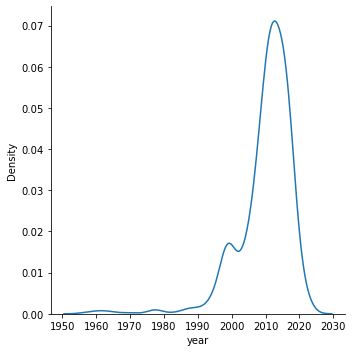

In [52]:
# график распределения по году
sns.displot(data=df.loc[df["year"] > 1899], x='year', kind="kde")

График распределения песен по жанрам
Самые распространённые жанры это Rap, Rock, Hip-Hop, Pop, Bard

In [70]:
# график распределения по жанрам
sns.displot(data=df, y='genre')

График распределения по длительности
Длина композиций в среднем колеблется от 150 до 250 секунд.

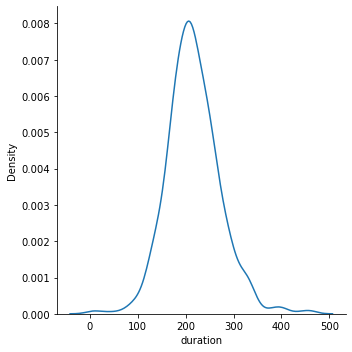

In [82]:
# график распределения по длительности
sns.displot(data=df.loc[df["duration"] < 1000], x='duration', kind="kde")

Гистограмма зависимости длины композиции от жанра
Самые длинные песни относятся к жанру Classical, самые короткие – Acoustic.

<AxesSubplot:xlabel='duration', ylabel='genre'>

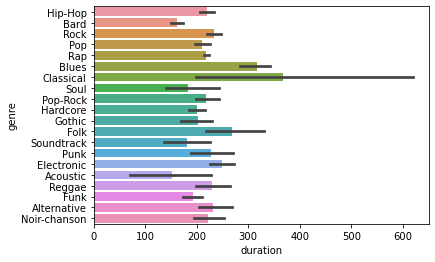

In [83]:
# гистограмма зависимости длины композиции от жанра
sns.barplot(x='duration', y='genre', data=df.loc[df["duration"] < 1500])

График распределения артистов по жанрам

In [88]:
# гистограмма зависимости количетства исполнителей от жанра
# df.groupby(['artist', 'genre']).size().groupby(level=1).max().plot(kind='bar')
# df.groupby(['artist', 'genre']).size().count(level)
# df.groupby(['genre']).agg({'artist':'count'})

Станадартизация данных
Данные будут отвечать двум условиям:
•	стандартное отклонение равно 1
•	среднее значение всех значений равно 0

In [4]:
# станадартизация данных
df_metrics = df.loc[:, 'rate':]
scaler = StandardScaler()
columns_list = list(df_metrics.columns.values)
# print(columns_list)
# genre_list = columns_list[-1]
# df_sorted = df_metrics.sort_values("genre_int")
scaled_array = scaler.fit_transform(df_metrics[columns_list[:-1]])
df_scaled = pd.DataFrame(scaled_array, columns = columns_list[:-1])
y = df[["genre_int"]]
df_scaled.head()

rate      year  duration  mfcc_mean_1  mfcc_mean_2  mfcc_mean_3  \
0 -0.144625  0.697753 -0.133234    -0.487979    -0.210095     0.011653   
1 -0.144625 -0.919183 -0.820997    -1.540097     1.741321    -0.757289   
2 -0.144625 -0.838336  0.278329    -1.162893     1.817328    -0.689274   
3 -0.144625 -1.242570  0.813945     1.021455    -0.620469    -0.288922   
4 -0.144625  0.212672 -0.053604     0.397064    -0.146235    -0.458422   

   mfcc_mean_4  mfcc_mean_5  mfcc_mean_6  mfcc_mean_7  ...  contrast_std_6  \
0    -1.521960     0.059658     0.716089    -1.110738  ...       -0.281897   
1     0.189679     0.041817    -0.864160     0.458637  ...        0.794996   
2     0.660264     0.380764     0.078416     1.992652  ...        0.406137   
3     0.458015     2.070045     0.292008    -0.866390  ...        0.482408   
4    -0.017137    -1.462274     1.392471    -1.552423  ...        1.894330   

   contrast_std_7  centroid_mean  centroid_std  centroid_skew  rolloff_mean  \
0       -0.899548       0.343627      0.573152       1.343530      0.355075   
1        1.468591      -1.601481     -1.519054       0.741009     -1.651949   
2       -0.352974      -1.497126     -1.105944       0.599436     -1.474766   
3       -0.664725       0.694341     -0.472201      -1.064097      0.837697   
4       -0.403632       0.832794      0.533692      -0.227162      0.967436   

   rolloff_std  z_rate_mean  z_rate_std  artist_int  
0     0.524981     0.280398    1.660431   -0.897444  
1    -1.866591    -1.030561   -1.028328    1.363297  
2    -1.226424    -1.250686   -1.000829    1.363297  
3     0.277409     0.625531   -0.807589   -0.312311  
4     0.727860     1.195291    0.749604   -0.019745  

[5 rows x 65 columns]

In [4]:
# преобразование жанров

# s, genres_int = np.unique(y, return_inverse=True)
# i = 0
# genres_new = []
# genres_dict = {}
# for genre in genres_int:
#     if genres_dict.get(genre) is not None:
#         genres_new.append(genres_dict.get(genre))
#     else:
#         genres_dict[genre] = i
#         genres_new.append(i)
#         i+=1
# y_new = pd.DataFrame(genres_new, columns=["genre_int"])
# y_new.head()
# df.head()

Index(['genre', 'artist', 'album', 'file_name', 'rate', 'year', 'duration',
       'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4',
       'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8',
       'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12',
       'mfcc_mean_13', 'mfcc_mean_14', 'mfcc_mean_15', 'mfcc_mean_16',
       'mfcc_mean_17', 'mfcc_mean_18', 'mfcc_mean_19', 'mfcc_mean_20',
       'mfcc_std_1', 'mfcc_std_2', 'mfcc_std_3', 'mfcc_std_4', 'mfcc_std_5',
       'mfcc_std_6', 'mfcc_std_7', 'mfcc_std_8', 'mfcc_std_9', 'mfcc_std_10',
       'mfcc_std_11', 'mfcc_std_12', 'mfcc_std_13', 'mfcc_std_14',
       'mfcc_std_15', 'mfcc_std_16', 'mfcc_std_17', 'mfcc_std_18',
       'mfcc_std_19', 'mfcc_std_20', 'contrast_mean_1', 'contrast_mean_2',
       'contrast_mean_3', 'contrast_mean_4', 'contrast_mean_5',
       'contrast_mean_6', 'contrast_mean_7', 'contrast_std_1',
       'contrast_std_2', 'contrast_std_3', 'contrast_std_4', 'contrast_std_5',
       '

Cлучайное разбиение на две части в указанной пропорции.  
Соотношение обучающей и тестовой выборки - 90%/10%. 

In [5]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
                                    df_scaled, y, test_size=0.1, random_state=5)
# X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.1, random_state=42)
print("X_train: {}".format(X_train.shape))
print("X_test: {}".format(X_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))
le = LabelEncoder()
y_train = le.fit_transform(y_train.values.ravel())

X_train: (648, 65)
X_test: (72, 65)
y_train: (648, 1)
y_test: (72, 1)


Получение весов классов с целью решить проблему неравномерного распределния жанров

In [7]:
# Получение весов классов
class_weights = list(compute_class_weight('balanced', classes=np.unique(y), y=y.values.reshape(-1)))
weights = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    weights[i] = class_weights[val-1]
y_train

Функция расчета метрик
Функция обучения модели

In [90]:
# classifier
def print_metrics(y_test_inner, y_pred_inner):
    # коэффициент детерминации
    r2_score_one = r2_score(y_test_inner, y_pred_inner)
    print('R2 Score:', r2_score_one)
    # RMSE Computation 
    rmse = np.sqrt(mean_squared_error(y_test_inner, y_pred_inner)) 
    print("RMSE : % f" %(rmse))
    # средняя абсолютная ошибка
    mae = mean_absolute_error(y_test_inner, y_pred_inner)
    print("MAE : % f" %(mae))
    # надежность
    pr_sc = precision_score(y_test_inner, y_pred_inner, average='weighted') # labels=np.unique(y_pred_inner)
    print("Precision : % f" %(pr_sc))
    # чувствительность
    r_sc = recall_score(y_test_inner, y_pred_inner, average="weighted") # labels=np.unique(y_pred_inner)
    print("Recall : % f" %(r_sc))
    # точность 
    ac_sc = round(accuracy_score(y_test_inner, y_pred_inner), 5)
    print("Accuracy : % f" %(ac_sc))
    print(f"Time checkpoint: {time.time() - t1}")

def model_assess(model, title = "Default"):
    # обучение
    t0 = time.time()
    print('\nTitle:', title)
    # model.fit(X_train, y_train.values.ravel())
    #if title in ['KNN', "Neural Nets"]:
    model.fit(X_train, y_train)
    #else:
        #model.fit(X_train, y_train, sample_weight=weights)
    y_pred = model.predict(X_test)
    y_pred = le.inverse_transform(y_pred)
    print(f"Time: {time.time() - t0}")
    print_metrics(y_test, y_pred) 

Обучение семи моделей классифкации

In [9]:
# метод опорных векторов
svc = SVC(kernel='rbf')
model_assess(svc, "Support Vector Machine")
# алгоритм Баейса
nb = GaussianNB()
model_assess(nb, "Naive Bayes")
# алгоритм k-ближайших соседей
knn = KNeighborsClassifier(n_neighbors=10)
model_assess(knn, "KNN")
# логистическая регрессия
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=1000)
model_assess(lg, "Logistic Regression")
# случайный лес
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")
# многослойный персептрон
nn = MLPClassifier(solver='lbfgs', max_iter=10000, alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")
# деревья с градиентным бустингом
xgb = XGBClassifier(n_estimators=1000)
model_assess(xgb, "XGBClassifier")


Title: Support Vector Machine
Time: 0.09829521179199219
R2 Score: -0.2988093194260488
RMSE :  20.105624
MAE :  12.680556
Precision :  0.548266
Recall :  0.680000
Accuracy :  0.472220
Time checkpoint: 5072.218389034271

Title: Naive Bayes
Time: 0.005795001983642578
R2 Score: -0.5969932696890572
RMSE :  22.294431
MAE :  14.541667
Precision :  0.539978
Recall :  0.484848
Accuracy :  0.444440
Time checkpoint: 5072.2331211566925

Title: KNN
Time: 0.08182406425476074
R2 Score: -0.6638860774478494
RMSE :  22.756562
MAE :  14.805556


/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision :  0.420622
Recall :  0.483871
Accuracy :  0.416670
Time checkpoint: 5072.330636024475

Title: Logistic Regression
Time: 0.3744659423828125
R2 Score: -0.04663369791508498
RMSE :  18.048546
MAE :  10.944444
Precision :  0.537439
Recall :  0.578125
Accuracy :  0.513890
Time checkpoint: 5072.713814020157

Title: Random Forest


/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Time: 4.4524736404418945
R2 Score: -0.18117793767009394
RMSE :  19.173549
MAE :  12.069444
Precision :  0.577696
Recall :  0.629630
Accuracy :  0.472220
Time checkpoint: 5077.175081014633

Title: Neural Nets
Time: 55.874042987823486
R2 Score: -0.5013619908184155
RMSE :  21.616609
MAE :  13.527778
Precision :  0.576265
Recall :  0.500000
Accuracy :  0.444440
Time checkpoint: 5133.05770611763

Title: XGBClassifier


/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Time: 9.663295984268188
R2 Score: 0.506581870988015
RMSE :  12.392314
MAE :  6.902778
Precision :  0.687680
Recall :  0.718750
Accuracy :  0.638890
Time checkpoint: 5142.729667186737


/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
# xgb7 = XGBClassifier(n_estimators=1000)
# model_assess(xgb7, "XGBClassifier")

Определение оптимального значения параметра max_depth

In [12]:
# XGBClassifier max_depth
def find_max_depth(max_depth):
    for value in max_depth:
        xgb0 = XGBClassifier(n_estimators=1000, max_depth=value)
        model_assess(xgb0, "XGBClassifier")
find_max_depth(max_depth=[1, 6, 10, 20])


Title: XGBClassifier
R2 Score: 0.19782180635620505
RMSE :  15.800844
MAE :  9.000000
Accuracy :  0.611110
Time checkpoint: 2026.6470580101013

Title: XGBClassifier
R2 Score: 0.38591599228236184
RMSE :  13.824797
MAE :  7.041667
Accuracy :  0.652780
Time checkpoint: 2059.4527559280396

Title: XGBClassifier
R2 Score: 0.3939484842080341
RMSE :  13.734082
MAE :  6.958333
Accuracy :  0.652780
Time checkpoint: 2092.0688791275024

Title: XGBClassifier
R2 Score: 0.16948495984063927
RMSE :  16.077503
MAE :  8.375000
Accuracy :  0.625000
Time checkpoint: 2124.6038839817047


Определение оптимального значения параметра min_child_weight

In [16]:
# XGBClassifier min_child_weight
def find_min_child_weight(min_child_weight):
    for value in min_child_weight:
        xgb0 = XGBClassifier(n_estimators=1000, min_child_weight=value)
        model_assess(xgb0, "XGBClassifier")
find_min_child_weight(min_child_weight=[1, 5, 10])


Title: XGBClassifier
R2 Score: 0.3474939059045633
RMSE :  14.250731
MAE :  7.194444
Accuracy :  0.666670
Time checkpoint: 2198.1985750198364

Title: XGBClassifier
R2 Score: 0.43509269284953267
RMSE :  13.259692
MAE :  7.402778
Accuracy :  0.597220
Time checkpoint: 2228.0945930480957

Title: XGBClassifier
R2 Score: -0.07675554263635576
RMSE :  18.306420
MAE :  10.263889
Accuracy :  0.555560
Time checkpoint: 2256.4846551418304


Определение оптимального значения параметра gamma

In [18]:
# XGBClassifier gamma
def find_gamma(gamma):
    for value in gamma:
        xgb0 = XGBClassifier(n_estimators=1000, gamma=value)
        model_assess(xgb0, "XGBClassifier")
find_gamma(gamma=[0, 0.5, 1, 1.5, 2, 5])


Title: XGBClassifier
R2 Score: 0.3474939059045633
RMSE :  14.250731
MAE :  7.194444
Accuracy :  0.666670
Time checkpoint: 2372.380562067032

Title: XGBClassifier
R2 Score: 0.040697339299028634
RMSE :  17.279162
MAE :  9.458333
Accuracy :  0.638890
Time checkpoint: 2418.793559074402

Title: XGBClassifier
R2 Score: 0.18099819826743602
RMSE :  15.965675
MAE :  8.958333
Accuracy :  0.611110
Time checkpoint: 2467.4614672660828

Title: XGBClassifier
R2 Score: 0.17622332806717533
RMSE :  16.012148
MAE :  8.277778
Accuracy :  0.652780
Time checkpoint: 2517.3241391181946

Title: XGBClassifier
R2 Score: 0.05711932279151399
RMSE :  17.130626
MAE :  9.236111
Accuracy :  0.625000
Time checkpoint: 2568.5111269950867

Title: XGBClassifier
R2 Score: -0.03650383309770944
RMSE :  17.960992
MAE :  10.291667
Accuracy :  0.583330
Time checkpoint: 2619.2088730335236


Определение оптимального значения параметра subsample

In [20]:
# XGBClassifier subsample
def find_subsample(subsample):
    for value in subsample:
        xgb0 = XGBClassifier(n_estimators=1000, subsample=value)
        model_assess(xgb0, "XGBClassifier")
find_subsample(subsample=[0.6, 0.8, 1.0])


Title: XGBClassifier
R2 Score: 0.1144177651946422
RMSE :  16.601958
MAE :  9.125000
Accuracy :  0.638890
Time checkpoint: 2902.0101702213287

Title: XGBClassifier
R2 Score: 0.3573113960359404
RMSE :  14.143118
MAE :  7.972222
Accuracy :  0.625000
Time checkpoint: 2934.7839941978455

Title: XGBClassifier
R2 Score: 0.3474939059045633
RMSE :  14.250731
MAE :  7.194444
Accuracy :  0.666670
Time checkpoint: 2967.3243980407715


Определение оптимального значения параметра colsample_bytree

In [21]:
# XGBClassifier colsample_bytree
def find_colsample_bytree(colsample_bytree):
    for value in colsample_bytree:
        xgb0 = XGBClassifier(n_estimators=1000, colsample_bytree=value)
        model_assess(xgb0, "XGBClassifier")
find_colsample_bytree(colsample_bytree=[0.6, 0.8, 1.0])


Title: XGBClassifier
R2 Score: 0.2632866155504333
RMSE :  15.142380
MAE :  8.069444
Accuracy :  0.652780
Time checkpoint: 3050.8677082061768

Title: XGBClassifier
R2 Score: 0.18430044494799014
RMSE :  15.933455
MAE :  8.069444
Accuracy :  0.666670
Time checkpoint: 3080.124336242676

Title: XGBClassifier
R2 Score: 0.3474939059045633
RMSE :  14.250731
MAE :  7.194444
Accuracy :  0.666670
Time checkpoint: 3112.3183522224426


Определение оптимального значения параметра n_estimators

In [11]:
# XGBClassifier n_estimators
def find_n_estimators(n_estimators):
    for value in n_estimators:
        xgb0 = XGBClassifier(n_estimators=value)
        model_assess(xgb0, "XGBClassifier")
find_n_estimators(n_estimators=[100, 500, 1000, 1500])


Title: XGBClassifier
Time: 1.7360517978668213
R2 Score: 0.45057755228402296
RMSE :  13.076697
MAE :  7.138889
Precision :  0.672196
Recall :  0.718750
Accuracy :  0.638890
Time checkpoint: 5370.290315151215

Title: XGBClassifier


/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Time: 4.790674924850464
R2 Score: 0.3754737527789881
RMSE :  13.941843
MAE :  7.763889
Precision :  0.666466
Recall :  0.703125
Accuracy :  0.625000
Time checkpoint: 5375.090163946152

Title: XGBClassifier


/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Time: 8.683544158935547
R2 Score: 0.506581870988015
RMSE :  12.392314
MAE :  6.902778
Precision :  0.687680
Recall :  0.718750
Accuracy :  0.638890
Time checkpoint: 5383.785418987274

Title: XGBClassifier


/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Time: 13.000601053237915
R2 Score: 0.506581870988015
RMSE :  12.392314
MAE :  6.902778
Precision :  0.687680
Recall :  0.718750
Accuracy :  0.638890
Time checkpoint: 5396.801347017288


/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Определение оптимального значения параметра reg_lambda

In [30]:
# XGBClassifier reg_lambda
def find_reg_lambda(reg_lambda):
    for value in reg_lambda:
        xgb0 = XGBClassifier(n_estimators=1000, reg_lambda=value)
        model_assess(xgb0, "XGBClassifier")
find_reg_lambda(reg_lambda=[0.5, 1, 5, 10])


Title: XGBClassifier
Time: 9.02406930923462
R2 Score: -0.17220832168642675
RMSE :  19.100611
MAE :  10.583333
Precision :  0.548949
Recall :  0.583333
Accuracy :  0.583330
Time checkpoint: 8517.44772195816

Title: XGBClassifier


/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Time: 10.527404069900513
R2 Score: 0.506581870988015
RMSE :  12.392314
MAE :  6.902778
Precision :  0.611271
Recall :  0.638889
Accuracy :  0.638890
Time checkpoint: 8527.991557121277

Title: XGBClassifier


/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Time: 11.183470964431763
R2 Score: 0.16582571351894415
RMSE :  16.112883
MAE :  9.097222
Precision :  0.568058
Recall :  0.597222
Accuracy :  0.597220
Time checkpoint: 8539.192287921906

Title: XGBClassifier


/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Time: 11.256614208221436
R2 Score: -0.005712614049299569
RMSE :  17.692199
MAE :  9.875000
Precision :  0.585880
Recall :  0.611111
Accuracy :  0.611110
Time checkpoint: 8550.46547794342


/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
# cross validation 

# data_dmatrix = DMatrix(data=X_train, label=y_train)
# params = {
#           'eval_metric':'error',
#           'eta':0.01,
#           'subsample':1.0}
# xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=5, metrics = 'error',seed=42)
# xgb_cv

In [5]:
# !{sys.executable} -m pip uninstall -y xgboost
# !{sys.executable} -m pip install xgboost

In [58]:
# GridSearchCV

# parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False],
# 'positive': [True,False], 'n_jobs': [1, 2, 5, 10]}
# parameters = {'booster': ['dart', 'gbtree', 'gblinear']}
# X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.1)
# print(y_train)
# xgb = XGBClassifier(n_estimators=1000)
# grid_search = GridSearchCV(estimator=xgb, param_grid = parameters, scoring = 'accuracy')
# grid_search = grid_search.fit(X_train, y_train)
# print('R2 Score:', grid_search.best_score_)
# print('Parameters:', grid_search.best_params_)

In [59]:
# StratifiedKFold

# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0, 0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#          'max_depth': [1, 6]
#         }
# xgb = XGBClassifier(n_estimators=1000)
# skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)
# random_search = RandomizedSearchCV(xgb, param_distributions=params, scoring='accuracy', n_jobs=-1, cv=3, verbose=2, random_state=1001)
# random_search.fit(X_train, y_train)
# print('\n Best estimator:')
# print(random_search.best_estimator_)
# print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (2, 5))
# print(random_search.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search.best_params_)
# print('\n Best score:')
# print(random_search.best_score_)

In [60]:
# hyperopt для поиска оптимальных гиперпараметров

# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 1000,
#         'seed': 0
# }
# def objective(space):
#     clf=XGBClassifier(
#                     n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
#                     reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
#                     colsample_bytree=int(space['colsample_bytree']), 
#                     eval_metric="auc", early_stopping_rounds=10)
    
#     evaluation = [( X_train, y_train), ( X_test, y_test)]
    
#     clf.fit(X_train, y_train, eval_set=evaluation, verbose=False)
    

#     pred = clf.predict(X_test)
#     pred = le.inverse_transform(pred)
#     accuracy = accuracy_score(y_test, pred)
#     print ("SCORE:", accuracy)
#     return {'loss': -accuracy, 'status': STATUS_OK }

# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

# print("The best hyperparameters are : ","\n")
# print(best_hyperparams)

In [319]:
# деревья с градиентным бустингом

# xgb = XGBClassifier(
#     colsample_bytree=0.5330105854610062,
#     gamma= 2.111229000351042, 
#     max_depth= 3, 
#     min_child_weight= 4,
#     reg_alpha= 53.0, 
#     reg_lambda=  0.775512718059824,
#     n_estimators= 1000,
#     seed= 0
# )
# model_assess(xgb, "XGBClassifier")


Title: XGBClassifier
R2 Score: -1.0706390950778144
RMSE :  23.371695
MAE :  17.208333
Accuracy :  0.291670
Time checkpoint: 1397.1348526477814


Для улучшения качества модели попробуем понизить размерность датасета, 
то есть убрать признаки, которые не сильно влияют на результаты обучения.

In [11]:
# понижение размерности
def low_dimensions(dimension_model, title):
    print('\nTitle:', title)
    dimension_model.fit(X_train)
    X_train_pca = dimension_model.transform(X_train)
    X_test_pca = dimension_model.transform(X_test)
    xgb = XGBClassifier(n_estimators=1000)
    xgb.fit(X_train_pca, y_train)
    y_pred = xgb.predict(X_test_pca)
    y_pred = le.inverse_transform(y_pred)
    print_metrics(y_test, y_pred)
    
# Principal Component Analysis
pca = PCA(n_components=30)
low_dimensions(pca, "Principal Component Analysis")
# Independent Computing Architecture
pca = FastICA(n_components=30)
low_dimensions(pca, "Independent Computing Architecture")
# Truncated Singular Value Decomposition
pca = TruncatedSVD(n_components=30)
low_dimensions(pca, "Truncated Singular Value Decomposition")


Title: Principal Component Analysis
R2 Score: -0.25181924166086644
RMSE :  19.738569
MAE :  11.750000
Accuracy :  0.527780
Time checkpoint: 1680.72904920578

Title: Independent Computing Architecture
R2 Score: -0.4556660367523695
RMSE :  21.285102
MAE :  13.277778
Accuracy :  0.458330
Time checkpoint: 1697.7272050380707

Title: Truncated Singular Value Decomposition
R2 Score: -0.3023346908823161
RMSE :  20.132892
MAE :  12.555556
Accuracy :  0.486110
Time checkpoint: 1714.719365119934


Определим наиболее важные столбцы с точки хрения алгоритма XGBClassifier


Title: XGBClassifier
Time: 8.455409049987793
R2 Score: 0.506581870988015
RMSE :  12.392314
MAE :  6.902778
Precision :  0.611271
Recall :  0.638889
Accuracy :  0.638890
Time checkpoint: 10994.649874210358


/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

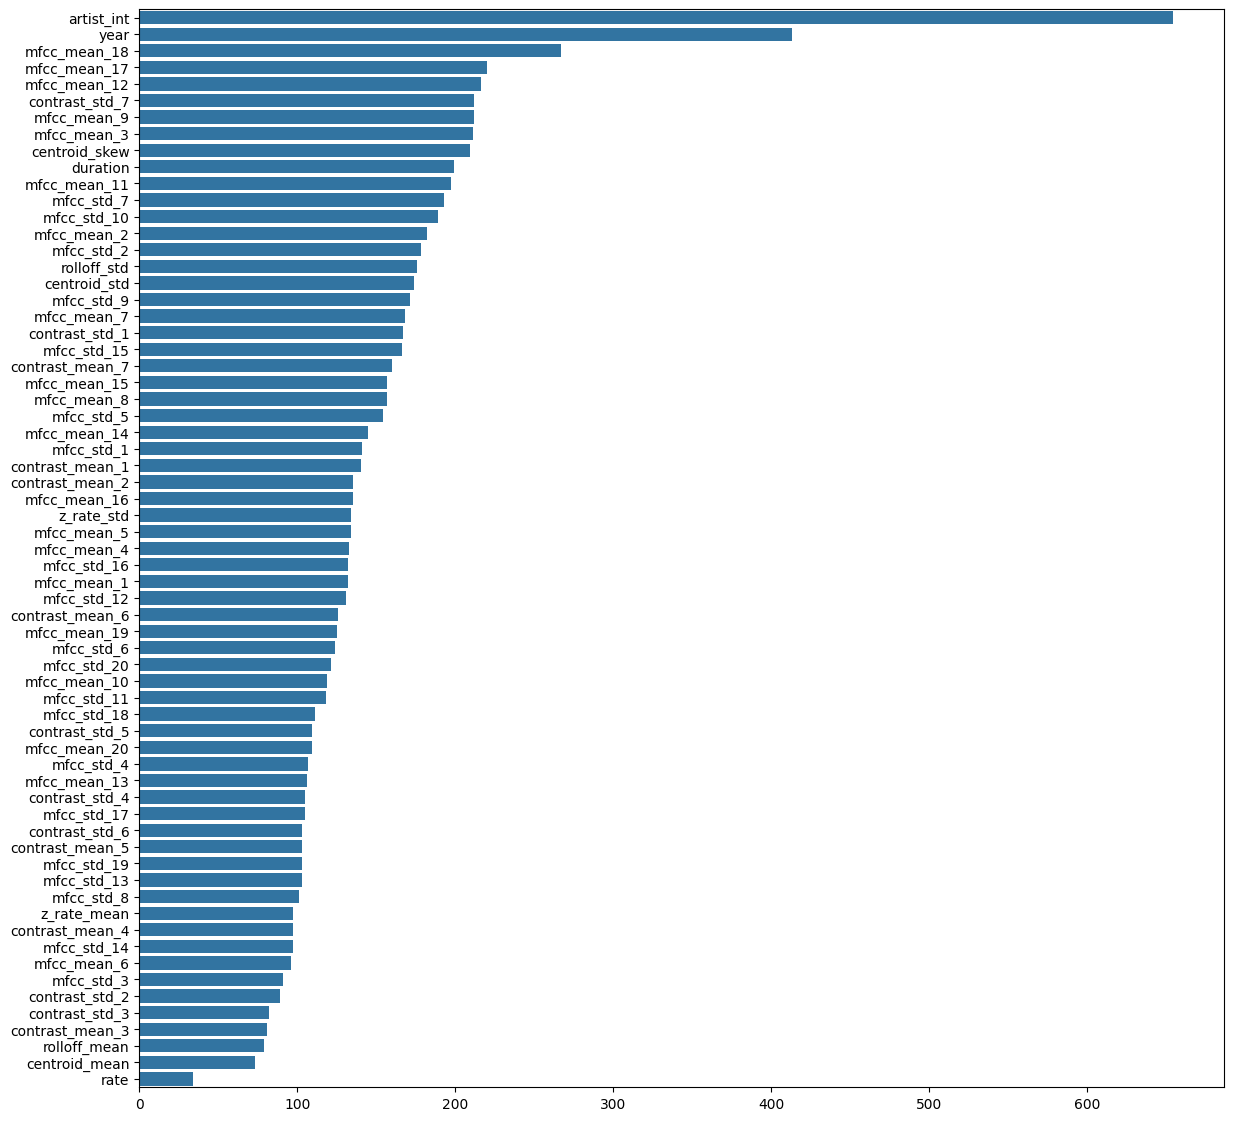

In [91]:
# важность столбцов
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.1, random_state=5)
le = LabelEncoder()
y_train = le.fit_transform(y_train.values.ravel())
xgb = XGBClassifier(n_estimators=1000)
model_assess(xgb, "XGBClassifier")
bst = xgb.get_booster()
imps = bst.get_fscore()
sorted_imps = {k: v for k, v in sorted(imps.items(), key=lambda item: item[1])}
sorted_imps_keys = list(sorted_imps.keys())
sorted_imps_keys.reverse()
vals = [float(imps[k]) for k in sorted_imps_keys]
fig, ax = plt.subplots(figsize=(14,14)) 
sns.barplot(x=vals, y=sorted_imps_keys, ax=ax)

Переобучение с понижением размерности на 10 признаках

In [92]:
# переобучение на 10 самых важных
X_train, X_test, y_train, y_test = train_test_split(df_scaled[sorted_imps_keys[:10]], y, test_size=0.1, random_state=5)
le = LabelEncoder()
y_train = le.fit_transform(y_train.values.ravel())
xgb = XGBClassifier(n_estimators=1000, max_depth=10)
model_assess(xgb, "XGBClassifier")


Title: XGBClassifier
Time: 4.709908962249756
R2 Score: 0.35601727233680436
RMSE :  14.157350
MAE :  7.069444
Precision :  0.628309
Recall :  0.652778
Accuracy :  0.652780
Time checkpoint: 11070.370915174484


/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Оценка оптимального количества кластеров
Из графика видно, что наибольшие изменения происходят, когда мы имеем 2–4  кластера:

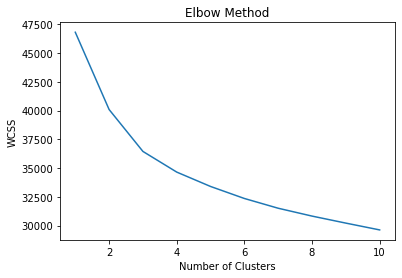

In [61]:
# оценка количества кластеров
wcss = []
# df_scaled = df_scaled[np.isfinite(df_scaled).all(1)]
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Разбиение на 3 кластера

In [10]:
# KMeans
kmeans_model = KMeans(n_clusters=3, random_state=0, init="k-means++")
clusters = kmeans_model.fit_predict(df_scaled)
# kmeans_model.cluster_centers_

Переобучим модель, используя номера кластеров, как один из признаков. 

In [13]:
# переобучение с учетом номера кластера
df_scaled_cluster = df_scaled
df_scaled_cluster["clusters"] = clusters
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.1, random_state=5)
le = LabelEncoder()
y_train = le.fit_transform(y_train.values.ravel())
xgb = XGBClassifier(n_estimators=1000, max_depth=10)
model_assess(xgb, "XGBClassifier")


Title: XGBClassifier
Time: 9.562607765197754
R2 Score: 0.5189429835625217
RMSE :  12.236103
MAE :  6.472222
Precision :  0.641984
Recall :  0.666667
Accuracy :  0.666670
Time checkpoint: 58653.461765766144


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Обратная стандартизация для анализа кластеров

In [14]:
# обратна стандартизация
unscaled_array = scaler.inverse_transform(df_scaled[columns_list[:-1]])
df_new = pd.DataFrame(unscaled_array, columns = columns_list[:-1])
df_new["genre_int"] = df_metrics[["genre_int"]]
df_new.insert(loc=0, column='file_name', value=df["file_name"])
df_new.insert(loc=0, column='artist', value=df["artist"])
df_new.insert(loc=0, column='genre', value=df["genre"])
df_new["clusters"] = clusters
df_new.head()

genre                                          artist          file_name  \
0  Hip-Hop                            Maitre Gims & Maluma  Hola Senorita.mp3   
1     Bard  музыка_ Сергей Никитин, стихи_ Дмитрий Сухарев     16 Пароход.mp3   
2     Bard  музыка_ Сергей Никитин, стихи_ Дмитрий Сухарев  14 Брич-Мулла.mp3   
3     Rock                                 The Cranberries      04 Zombie.mp3   
4      Pop                                   Андрей Гризли     Эта музыка.mp3   

      rate    year    duration  mfcc_mean_1  mfcc_mean_2  mfcc_mean_3  \
0  44100.0  2018.0  206.948788   -177.19870    129.53387   -13.279080   
1  44100.0  1998.0  134.582857   -239.88872    166.52751   -26.802689   
2  44100.0  1999.0  250.253061   -217.41316    167.96840   -25.606490   
3  44100.0  1994.0  306.610157    -87.25966    121.75427   -18.565372   
4  44100.0  2012.0  215.327347   -124.46374    130.74448   -21.546427   

   mfcc_mean_4  ...  centroid_mean  centroid_std  centroid_skew  rolloff_mean  \
0    22.691448  ...    2986.180771   1658.717569       3.236454   6247.813683   
1    41.114580  ...    1730.821257    894.767883       2.489141   3348.546879   
2    46.179688  ...    1798.171469   1045.611340       2.313547   3604.497543   
3    44.002800  ...    3212.528990   1277.016805       0.250250   6944.989506   
4    38.888523  ...    3301.885562   1644.309341       1.288309   7132.405308   

   rolloff_std  z_rate_mean  z_rate_std  artist_int  genre_int  clusters  
0  3287.090506     0.061122    0.084243        57.0       62.0         0  
1  1767.293394     0.038858    0.032790       227.0       34.0         2  
2  2174.106985     0.035119    0.033316       227.0       34.0         2  
3  3129.763396     0.066984    0.037014       101.0       44.0         1  
4  3416.015918     0.076660    0.066813       123.0       62.0         0  

[5 rows x 70 columns]

Номер кластера слабо влияет на жанр

<AxesSubplot:>

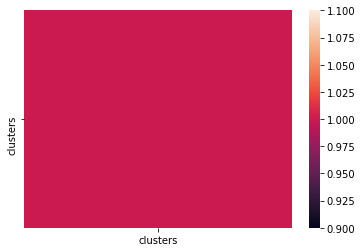

In [25]:
# тепловая карта зависимости жанра от кластера
# sns.barplot(x='clusters', y='genre', data=df_new)
# sns.pairplot(df_new[["clusters", "genre"]])
sns.heatmap(df_new[["clusters", "genre"]].corr())

В кластере номер два преобладают композиции жанра Bard 

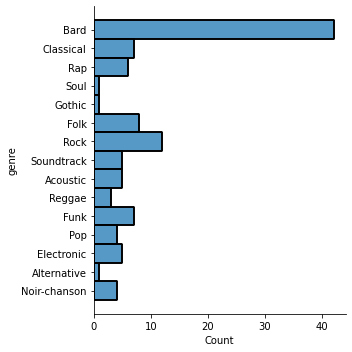

In [15]:
# график распределения по жанрам
sns.displot(data=df_new.loc[df_new["clusters"] == 2], y='genre')

Средняя длина в кластере два в нескольк рах меньше средней длины всего датасета 

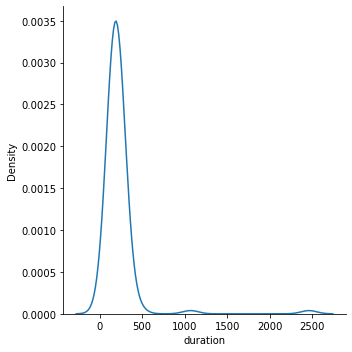

In [18]:
# график распределения по длительности
sns.displot(data=df_new.loc[df_new["clusters"] == 2], x='duration', kind="kde")

Переобучение на одном из кластеров

In [26]:
y_clusters = y.copy()
y_clusters["clusters"] = clusters
x_cluster_2 = df_scaled_cluster.loc[df_scaled_cluster["clusters"] == 2]
y_cluster_2 = y_clusters.loc[y_clusters["clusters"] == 2]
X_train, X_test, y_train, y_test = train_test_split(x_cluster_2, y_cluster_2[["genre_int"]], test_size=0.1, random_state=5)
le = LabelEncoder()
y_train = le.fit_transform(y_train.values.ravel())
xgb = XGBClassifier(n_estimators=1000, max_depth=10)
model_assess(xgb, "XGBClassifier")


Title: XGBClassifier
Time: 1.9556047916412354
R2 Score: -0.56507363991584
RMSE :  20.830666
MAE :  13.250000
Precision :  0.428571
Recall :  0.500000
Accuracy :  0.500000
Time checkpoint: 59659.61945486069


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Тепловая карта корреляционной матрицы с учетом номера кластера

<AxesSubplot:>

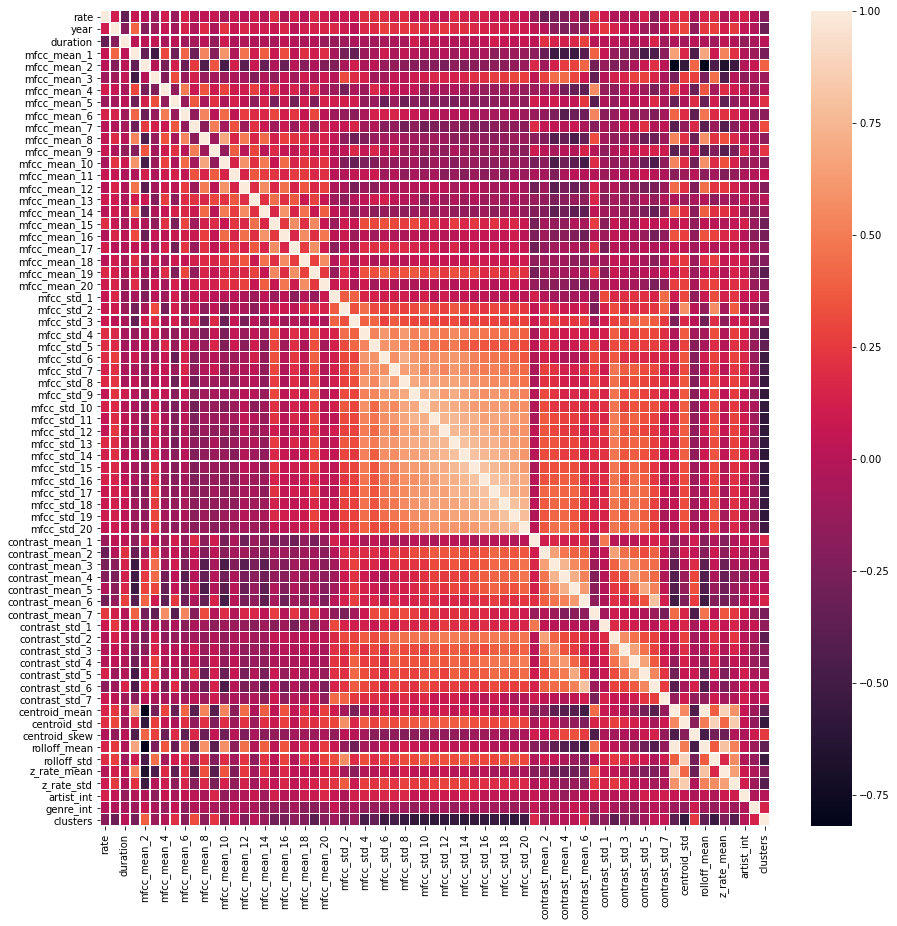

In [152]:
# тепловая карта корреляционной матрицы
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(df_new.loc[:, 'rate':].corr(), linewidths=.2, ax=ax)

Для оценки результатов приведем признаки наиболее сильно влияющие на результаты работы  модели, а также сравним с аналогичными решениями, предположим, что можно было бы улучшить.

In [29]:
sns.barplot(x=vals, y=sorted_imps_keys, ax=ax)

<AxesSubplot:>

Видно, что наибольшее влияние оказывают год выпуска композции и исполнитель композиции. Посомотрим как это выглядит на графике.

<AxesSubplot:xlabel='year', ylabel='genre'>

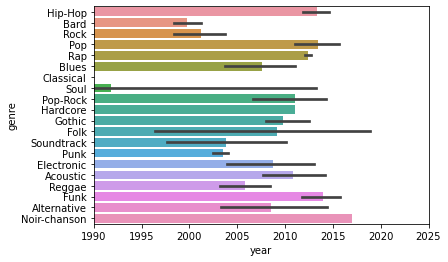

In [33]:
# гистограмма зависимости длины композиции от жанра
fig, ax = plt.subplots()
ax.set_xlim(1990,2025)
sns.barplot(x='year', y='genre', data=df, ax=ax)

Гистограмма зависимости mfcc_mean_1 от жанра

<Axes: xlabel='mfcc_mean_1', ylabel='genre'>

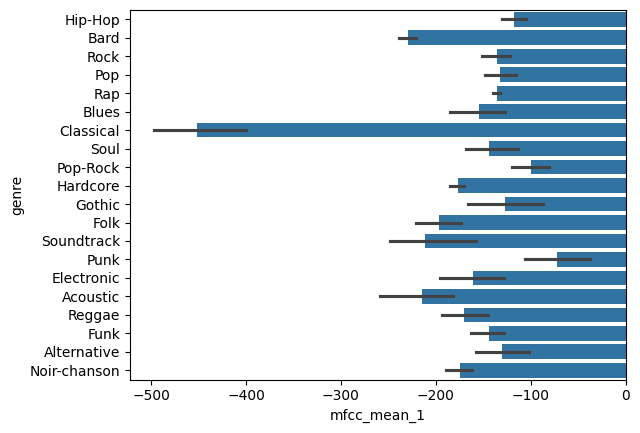

In [26]:
sns.barplot(x='mfcc_mean_1', y='genre', data=df)

Гистограмма зависимости mfcc_mean_2 от жанра

<Axes: xlabel='mfcc_mean_2', ylabel='genre'>

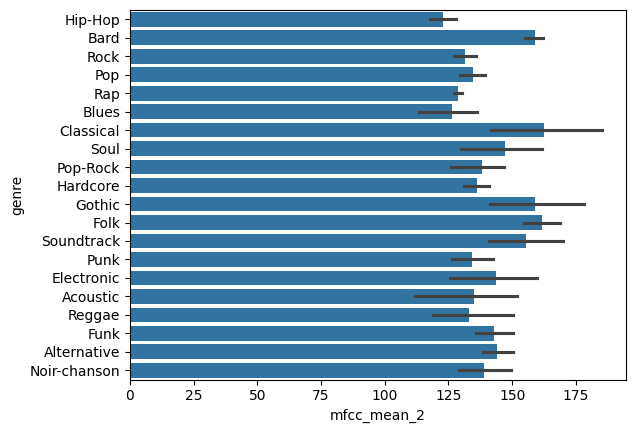

In [27]:
sns.barplot(x='mfcc_mean_2', y='genre', data=df)

Построим диаграммы корреляция для первой десятки признаков. Как видно из графика некоторые признаки коррелируют друг между другом, однако особого влияния (последняя строка) на целевой признак – жанр, не оказывают:

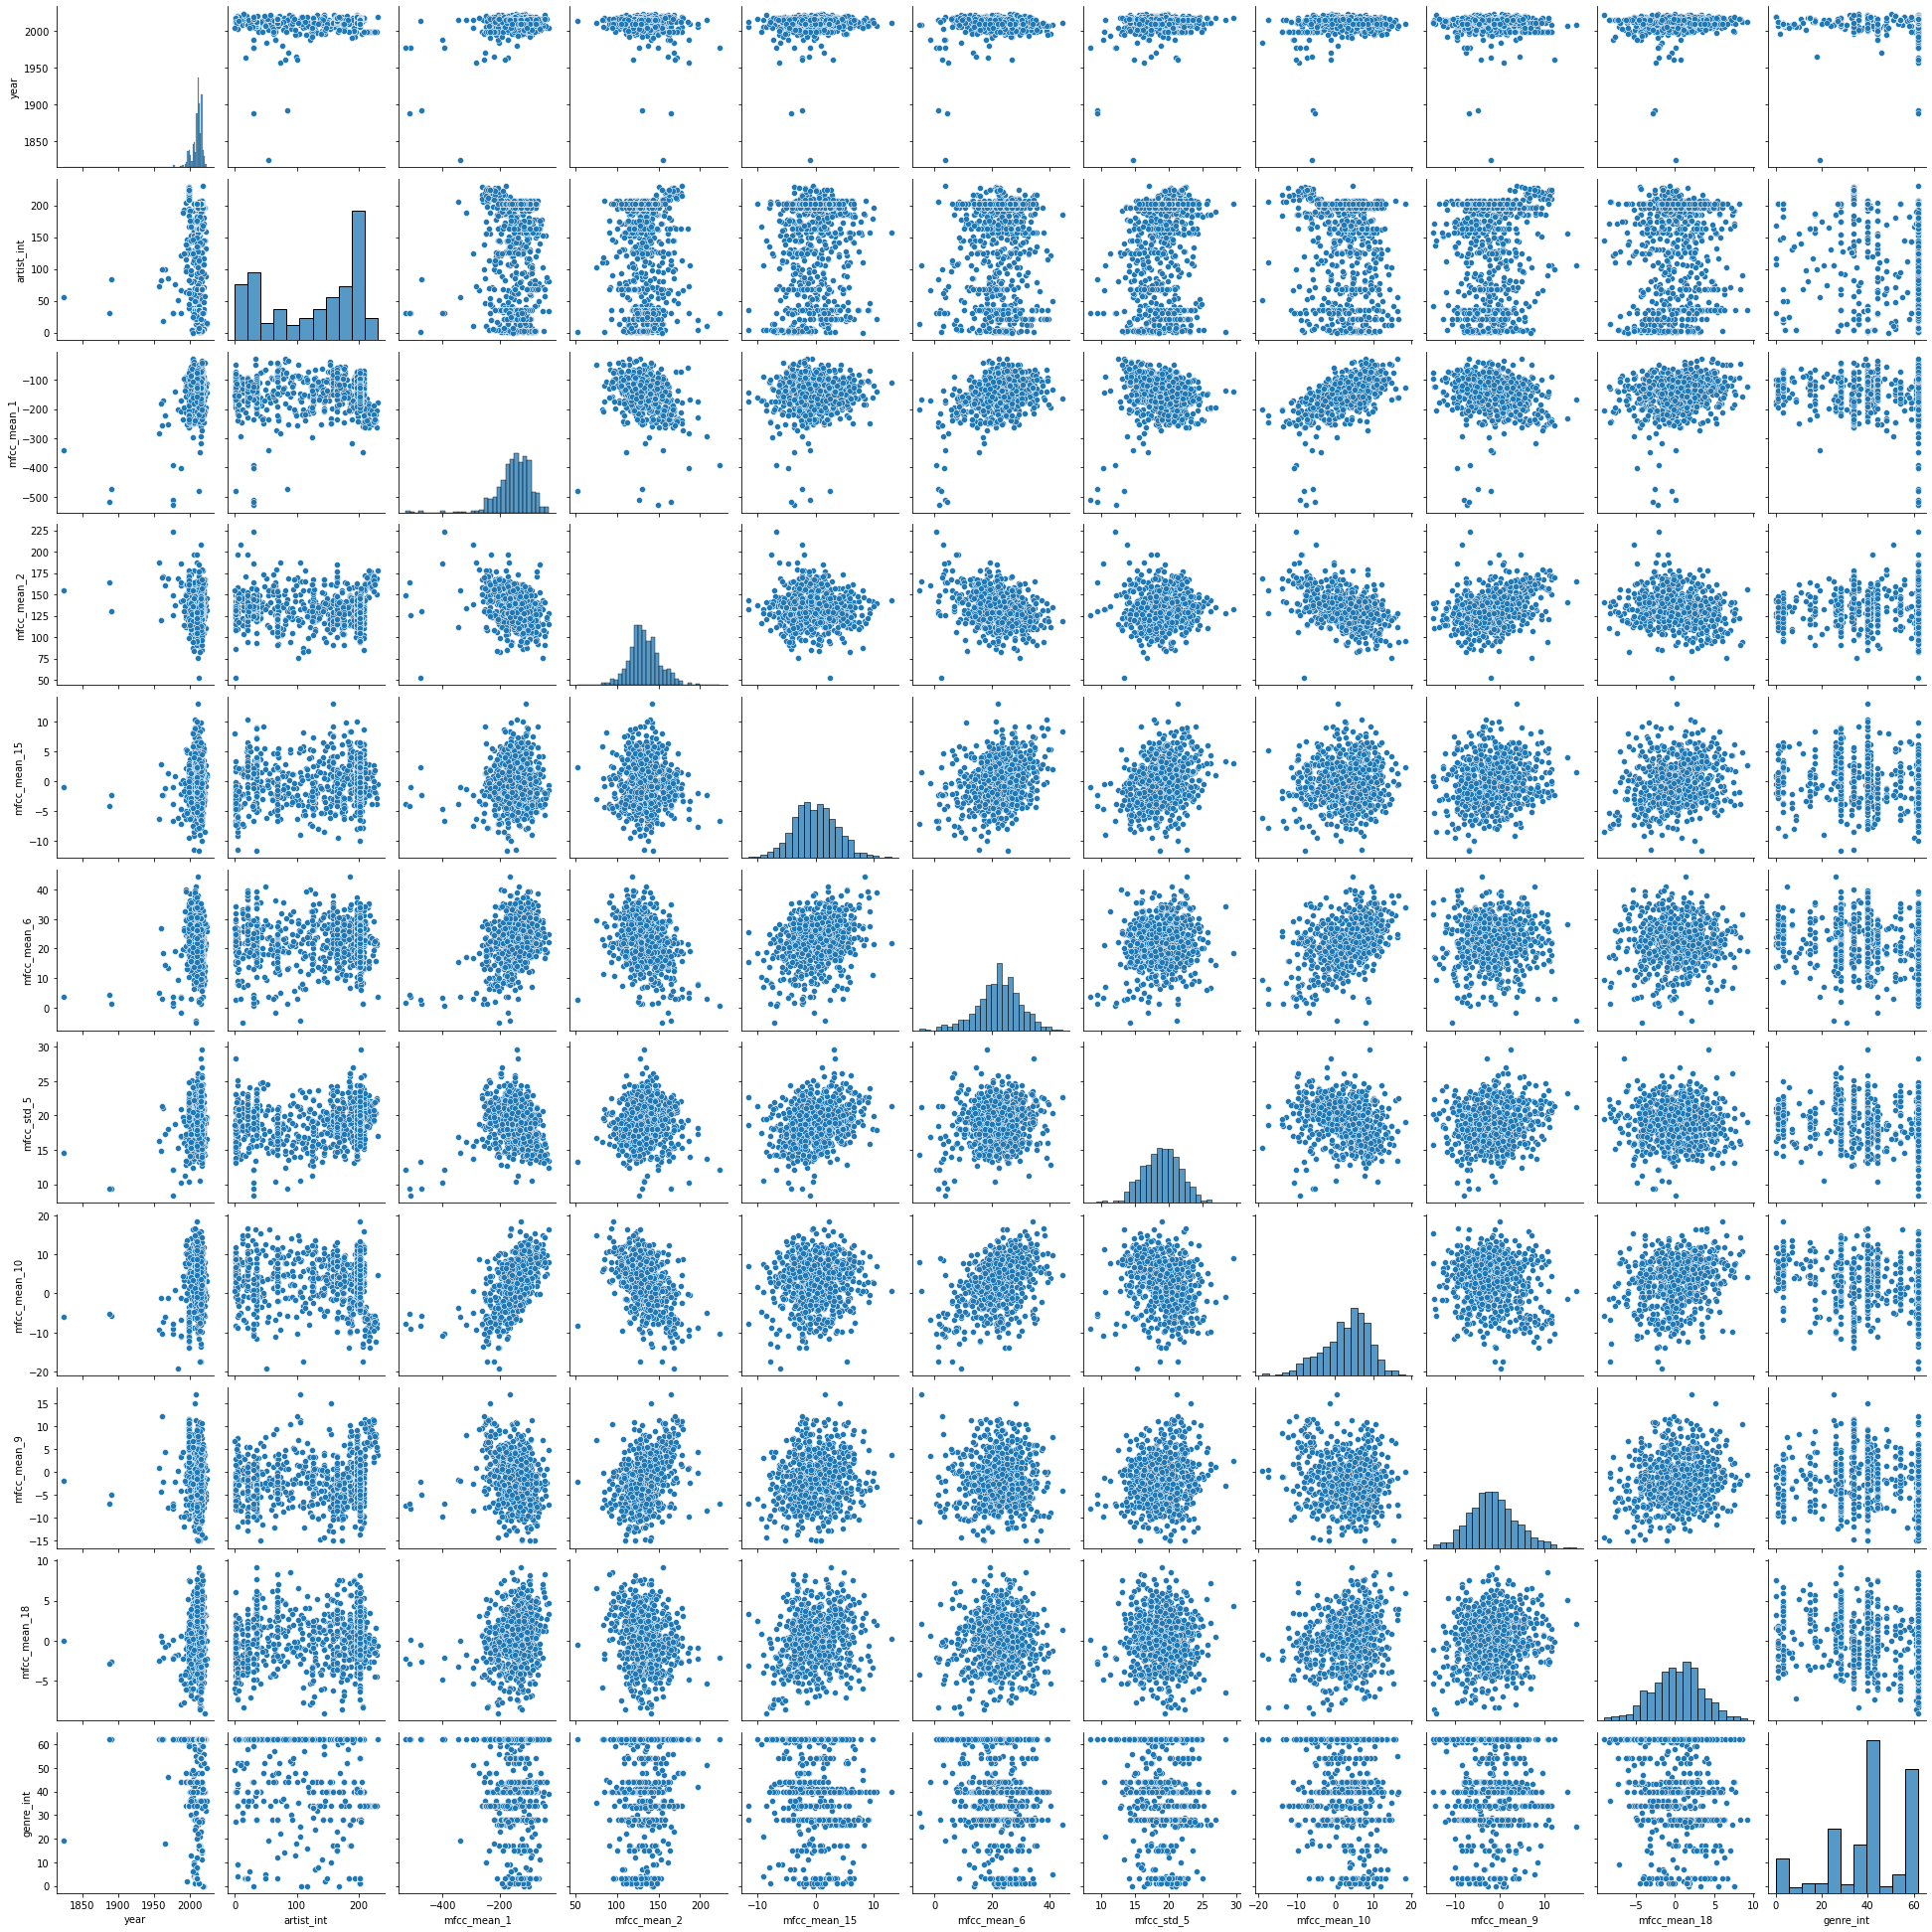

In [35]:
# парные диаграммы;
sns.pairplot(df[["year", "artist_int", "mfcc_mean_1", "mfcc_mean_2", "mfcc_mean_15", 
    "mfcc_mean_6", "mfcc_std_5", "mfcc_mean_10", "mfcc_mean_9", "mfcc_mean_18", "genre_int" ]])

In [ ]:
Кривые обучения большинства моделей, кроме XGBClassifier показывают, что модели непригодны для использования:

/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


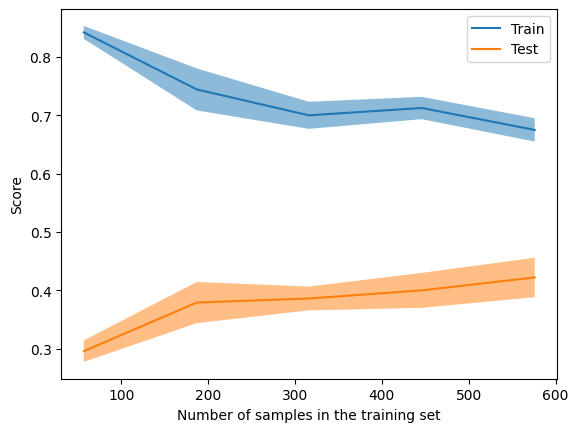

In [21]:
LearningCurveDisplay.from_estimator(svc, X=df_scaled, y=y.values.ravel())

/opt/anaconda3/envs/anaconda3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Text(0.5, 1.0, 'Learning Curve for LogisticRegression')

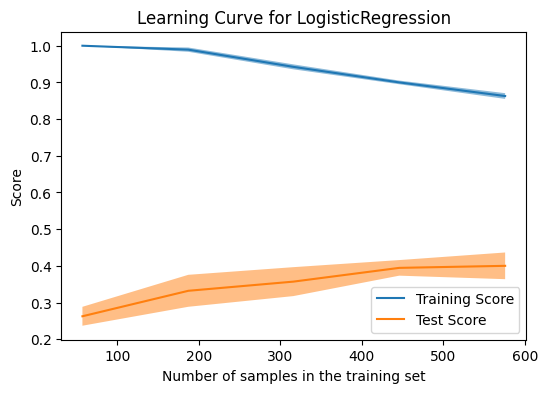

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharey=True)
LearningCurveDisplay.from_estimator(lg, X=df_scaled, y=y.values.ravel(), ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {lg.__class__.__name__}")

In [32]:
# LearningCurveDisplay.from_estimator(xgb, X=df_scaled, y=y.values.ravel())

[ 1.  3.  9. 26. 27. 28. 30. 33. 34. 36. 40. 41. 42. 43. 44. 45. 54. 60.
 61. 62.]
